In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pydrake.all import MathematicalProgram, Variables, SolutionResult

# Simple Verification Problem

Verification of the system
\begin{align}
\dot q = - q - \sin (q) \cos(q)
\end{align}
through SOS programming.

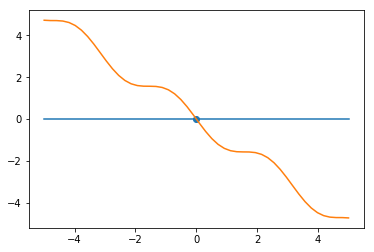

In [3]:
# plot of the stable dynamics
q = np.linspace(-5., 5.)
f = - q - np.sin(q)*np.cos(q)
plt.plot(q, np.zeros(f.shape))
plt.scatter(0., 0.)
plt.plot(q, f)
plt.show()

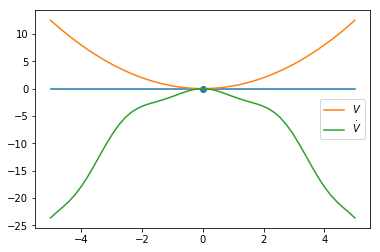

In [4]:
# trivial Lyapunov function
V = .5 * q**2
Vdot = - q**2 - q*np.sin(q)*np.cos(q)
plt.plot(q, np.zeros(f.shape))
plt.scatter(0., 0.)
plt.plot(q, V, label=r'$V$')
plt.plot(q, Vdot, label=r'$\dot V$')
plt.legend()
plt.show()

## Standard Approach

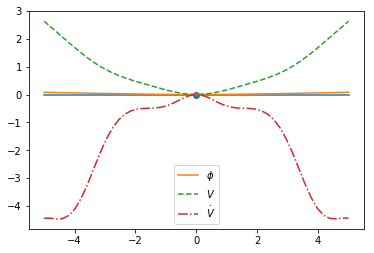

In [5]:
# set up optimization problem
nx = 3
prog = MathematicalProgram()
x = prog.NewIndeterminates(nx, 'x')

# dynamics in redundant coordinate system
# x = [q, sin(q), cos(q) - 1]'
x0d = - x[0] - x[1] * (x[2] + 1.)
x1d = (x[2] + 1.) * x0d
x2d = - x[1] * x0d
dynamics = [x0d, x1d, x2d]
constraint_set = x[1]**2 + x[2]**2 + 2.*x[2]

# Lyapunov function
V = prog.NewFreePolynomial(Variables(x), 2)
phi = .003 * x.dot(x)
prog.AddSosConstraint(V.ToExpression() - phi)

# V(0,0,0) = 0
V_0 = V.ToExpression().EvaluatePartial({x[0]: 0., x[1]: 0., x[2]: 0.})
prog.AddLinearConstraint(V_0 == 0.)

# V(pi,0,-2) = 0
V_pi = V.ToExpression().EvaluatePartial({x[0]: np.pi, x[1]: 0., x[2]: -2.})
prog.AddLinearConstraint(V_pi == 1.)

# time-derivative of the Lyapunov function
lam = prog.NewFreePolynomial(Variables(x), 2)
V_dot = V.ToExpression().Jacobian(x).dot(dynamics)
prog.AddSosConstraint(- V_dot + lam.ToExpression() * constraint_set)

# solve feasibility SDP
result = prog.Solve()
assert(result == SolutionResult.kSolutionFound)

# evaluate Lyapunov function
V_opt = prog.SubstituteSolution(V)
V_dot_opt = prog.SubstituteSolution(V_dot)
def V_eval(q):
    return V_opt.Evaluate({x[0]: q, x[1]: np.sin(q), x[2]: np.cos(q) - 1.})
def V_dot_eval(q):
    return V_dot_opt.Evaluate({x[0]: q, x[1]: np.sin(q), x[2]: np.cos(q) - 1.})
def phi_eval(q):
    return phi.Evaluate({x[0]: q, x[1]: np.sin(q), x[2]: np.cos(q) - 1.})

# plot Lyapunov function
q_samples = np.linspace(-5., 5.)
V_samples = [V_eval(q) for q in q_samples]
Vdot_samples = [V_dot_eval(q) for q in q_samples]
phi_samples = [phi_eval(q) for q in q_samples]
plt.scatter(0., 0.)
plt.plot(q_samples, np.zeros(q_samples.shape))
plt.plot(q_samples, phi_samples, label=r'$\phi$')
plt.plot(q_samples, V_samples, '--', label=r'$V$')
plt.plot(q_samples, Vdot_samples, '-.', label=r'$\dot V$')
plt.legend()
plt.show()

## How to Avoid the Change of Coordinates?

Derive the Lyapunov function using the basis functions $b =\{q, \sin(q), \cos(q) \}$

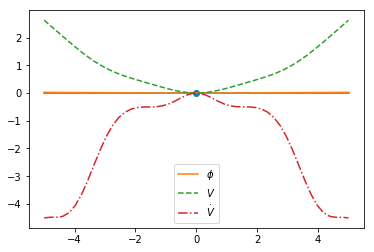

In [6]:
"""
Conditions on the basis function:
- d b_i(x) / d x_j \in affspan(b(x))
- f_i(x) polynomial in b(x)
- x = 0 <=> b(x) = b_0
"""

# set up optimization problem
prog = MathematicalProgram()
b = prog.NewIndeterminates(3, "b")
b_0 = np.array([0., 0., 1.])
dbdq = np.array([1., b[2], - b[1]])

# dynamics wrt the basis function
dqdt = - b[0] - b[1] * b[2]

# Lyapunov function
V = prog.NewFreePolynomial(Variables(b), 2)
phi = .001 * (b - b_0).dot(b - b_0)
prog.AddSosConstraint(V.ToExpression() - phi)

# V(b(0)) = 0
V_0 = V.ToExpression().EvaluatePartial({b_i: b_0[i] for i, b_i in enumerate(b)})
prog.AddLinearConstraint(V_0 == 0.)

# V(b(pi)) = pi
V_pi = V.ToExpression().EvaluatePartial({b[0]: np.pi, b[1]: 0., b[2]: -1.})
prog.AddLinearConstraint(V_pi == 1.)

# time-derivative of the Lyapunov function
dVdt = V.ToExpression().Jacobian(b).dot(dbdq)*dqdt
prog.AddSosConstraint(- dVdt)

# solve feasibility SDP
result = prog.Solve()
assert(result == SolutionResult.kSolutionFound)

# evaluate Lyapunov function
V_opt = prog.SubstituteSolution(V)
V_dot_opt = prog.SubstituteSolution(dVdt)
def V_eval(q):
    return V_opt.Evaluate({b[0]: q, b[1]: np.sin(q), b[2]: np.cos(q)})
def V_dot_eval(q):
    return V_dot_opt.Evaluate({b[0]: q, b[1]: np.sin(q), b[2]: np.cos(q)})
def phi_eval(q):
    return phi.Evaluate({b[0]: q, b[1]: np.sin(q), b[2]: np.cos(q)})

# plot Lyapunov function
q_samples = np.linspace(-5., 5.)
V_samples = [V_eval(q) for q in q_samples]
Vdot_samples = [V_dot_eval(q) for q in q_samples]
phi_samples = [phi_eval(q) for q in q_samples]
plt.scatter(0., 0.)
plt.plot(q_samples, np.zeros(q_samples.shape))
plt.plot(q_samples, phi_samples, label=r'$\phi$')
plt.plot(q_samples, V_samples, '--', label=r'$V$')
plt.plot(q_samples, Vdot_samples, '-.', label=r'$\dot V$')
plt.legend()
plt.show()